In [1]:
import numpy as np
import pysindy as ps

from scipy.integrate import solve_ivp
from pysindy.utils import linear_damped_SHO, cubic_damped_SHO, van_der_pol, lotka

import matplotlib.pyplot as plt

from numpy import genfromtxt

import deepSI
from deepSI import System_data

import torch
from torch import nn
from torch.nn import functional as F

import csv
import os

from scipy.io import loadmat

import torch.nn.utils.prune as prune

c:\Users\20173928\Miniconda3\envs\sindy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# integrator_keywords = {}
# integrator_keywords['rtol'] = 1e-12
# integrator_keywords['method'] = 'LSODA'
# integrator_keywords['atol'] = 1e-12

# # training data
# dt = 0.01
# t_train = np.arange(0, 50, dt)
# t_train_span = (t_train[0], t_train[-1])
# x0_train = [2, 0]
# x_train = solve_ivp(van_der_pol, t_train_span,
#                     x0_train, t_eval=t_train, **integrator_keywords).y.T

# # training data
# t_test = np.arange(0, 25, dt)
# t_test_span = (t_test[0], t_test[-1])
# x0_test = [0.1, 0.5]
# x_test = solve_ivp(van_der_pol, t_test_span,
#                     x0_test, t_eval=t_test, **integrator_keywords).y.T

u_train = None
u_test = None

In [3]:
# data dir and file
save_dir = r"C:\Users\20173928\OneDrive - TU Eindhoven\Documents\Master\thesis\mscth\data\own_data"

out = loadmat(os.path.join(save_dir,'MSD_x_data.mat'))
x_data = out['x']

save_dir = r"C:\Users\20173928\OneDrive - TU Eindhoven\Documents\Master\thesis\mscth\data\own_data"
out = loadmat(os.path.join(save_dir,'MSD_u_data.mat'))
u = out['u']

dt =1

x_data = np.c_[x_data, u]

x_train = x_data[:10000]
x_test = x_data[-1000:]

u_train = x_data[:10000,-1]
u_test = x_data[-1000:,-1]

In [4]:
def normalize(y):
  y_mu = np.mean(y)
  y_std = np.std(y)
  y_norm = (y-y_mu)/y_std

  return y_norm, y_std, y_mu

In [5]:
# generate function set
# x_train, x_std, x_mu = normalize(x_train)

degree = 2
# feature_library=ps.PolynomialLibrary(degree=degree)
p_library=ps.PolynomialLibrary(degree=degree, include_interaction=False)

functions = [lambda x : np.sin(x)]
# feature_library = ps.CustomLibrary(library_functions=functions)
c_library = ps.CustomLibrary(library_functions=functions)

feature_library = ps.ConcatLibrary([p_library, c_library])

# train
train_x = x_train[:,:-1]
Theta = torch.as_tensor(np.array(feature_library.fit(x_train).transform(x_train))).to(torch.float32)

if u_train is not None:
  target_x = torch.as_tensor(x_train[1:,:-1]).to(torch.float32)
else:
  target_x = torch.as_tensor(x_train[1:,:]).to(torch.float32)

# test
test_x = x_test[:,:-1]
Theta_test = torch.as_tensor(np.array(feature_library.fit(x_test).transform(x_test))).to(torch.float32)
if u_test is not None:
  target_x_test = torch.as_tensor(x_test[1:,:-1]).to(torch.float32)
else:  
  target_x_test = torch.as_tensor(x_test[1:,:]).to(torch.float32)

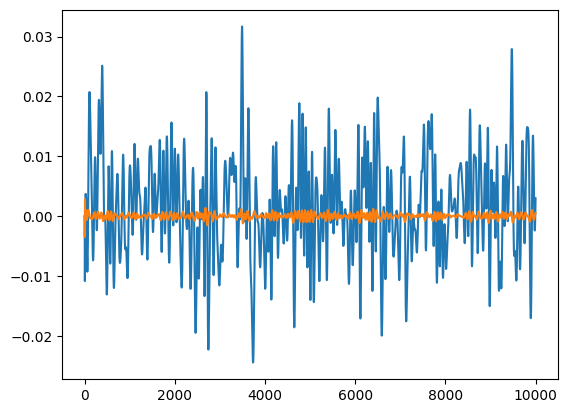

In [6]:
plt.plot(x_train[:,:-1])

In [7]:
import torch
from torch import nn
from torch.nn import functional as F

class MLP(torch.nn.Module):
    def __init__(self, n_in, n_out):#, threshold=0):
        super(MLP, self).__init__()
        
        self.layer = nn.Linear(n_in, n_out, bias=False)# if threshold==0 else PruningLinear(n_in, n_out, threshold)
        # self.layer = 

    def forward(self, x):
        out = self.layer(x)
        return out
    

In [8]:
n_in = Theta.shape[-1]
n_out = target_x.shape[-1]

model = MLP(n_in, n_out)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [10]:
def SINDyLoss(X_pred, X_true, Theta, Xi, l):
    params = [x.view(-1) for x in Xi]
    l1_params = torch.cat(params)
    Xi = Xi[0]
    pred_loss = 1/2 * nn.functional.mse_loss(X_true, X_pred)
    l1_loss = l*torch.norm(l1_params, 1)
    return pred_loss, l1_loss

In [11]:
epochs = 50000

lambda_1, lb = 1e-4, 0

batch_size = 1024
n_batches = Theta.shape[0]//batch_size

## PRUNING
pruning_method = prune.l1_unstructured
module = model.layer

losses = []

for epo in range(epochs):
    for batch in range(n_batches):
        Theta_b    = Theta[batch*batch_size:batch*batch_size+batch_size,:]
        target_x_b = target_x[batch*batch_size:batch*batch_size+batch_size,:]
        
        optimizer.zero_grad()
        output = model(Theta_b)

        # loss
        Xi = [*model.parameters()]

        pred, l1 = SINDyLoss(output, target_x_b, Theta_b, Xi, lb)
        loss = l1+pred
        losses.append(loss.detach().numpy())

        loss.backward()

        optimizer.step()

    if (epo%(epochs//10)==0 or epo==epochs-1) and epo != 0:
        epo_p = epo if epo != epochs-1 else epo+1
        print("Epoch {} train loss: {:.10f}".format(epo_p, loss))
        print("pred loss {:.4f}, l1 loss: {:.4f}".format(pred, l1))

    # pruning
    if epo%1000==0:
        pruning_method(module, name="weight", amount=0.05)
        lb = lambda_1
    else:
        lb=0

print(list(module.named_parameters()))
prune.remove(module, 'weight')
print(list(module.named_parameters()))


Epoch 5000 train loss: 0.0000000002
pred loss 0.0000, l1 loss: 0.0000
Epoch 10000 train loss: 0.0000000003
pred loss 0.0000, l1 loss: 0.0000
Epoch 15000 train loss: 0.0000000004
pred loss 0.0000, l1 loss: 0.0000
Epoch 20000 train loss: 0.0000000006
pred loss 0.0000, l1 loss: 0.0000
Epoch 25000 train loss: 0.0000000003
pred loss 0.0000, l1 loss: 0.0000
Epoch 30000 train loss: 0.0000000003
pred loss 0.0000, l1 loss: 0.0000
Epoch 35000 train loss: 0.0000000003
pred loss 0.0000, l1 loss: 0.0000
Epoch 40000 train loss: 0.0000000004
pred loss 0.0000, l1 loss: 0.0000
Epoch 45000 train loss: 0.0000000009
pred loss 0.0000, l1 loss: 0.0000
Epoch 50000 train loss: 0.0000000004
pred loss 0.0000, l1 loss: 0.0000
[('weight_orig', Parameter containing:
tensor([[-0.1508,  0.1667,  0.2247,  0.0673, -0.1682,  0.2967,  0.1833,  0.6283,
          0.1501,  0.0573],
        [ 0.1833, -0.4672, -0.0270,  0.1568, -0.1674, -0.1846, -0.1835, -0.0271,
          0.2141, -0.1837]], requires_grad=True))]
[('weight',

In [12]:
test_pred = model(Theta_test).detach().numpy()
test_true = target_x_test.detach().numpy()
RMS = np.sqrt(np.mean((test_pred[:-1]-test_true)**2))
RMS/np.std(test_true)


0.004733209

In [26]:
threshold = 0
params = [x.detach().numpy() for x in model.parameters()][0]

NN_p_1 = params[0,:]
NN_p_2 = params[1,:]
NN_p = [NN_p_1, NN_p_2]
NN_p

[array([-0.        ,  0.        ,  0.22470151,  0.06732184, -0.        ,
         0.29672903,  0.        ,  0.6283191 ,  0.15013607,  0.05726988],
       dtype=float32),
 array([ 0.        , -0.4671708 , -0.        ,  0.15676408, -0.        ,
        -0.18457139, -0.        , -0.        ,  0.21411982, -0.        ],
       dtype=float32)]

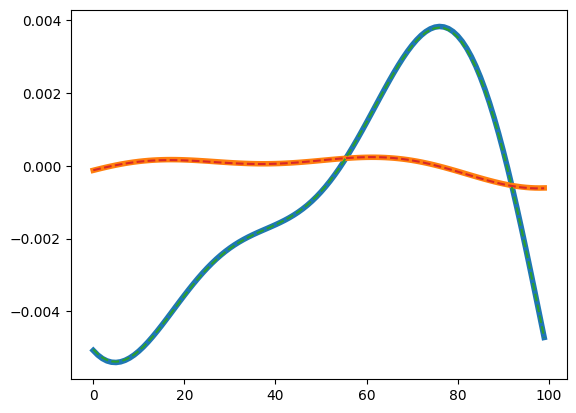

In [14]:
x_ptest = np.matmul(Theta_test.detach().numpy(),np.transpose(params))

plt.plot(x_test[1:101,:-1], linewidth=4.0)
plt.plot(x_ptest[:100],'--')

In [15]:
# feature_library=ps.PolynomialLibrary(degree=degree)

s_model = ps.SINDy(
    optimizer=ps.STLSQ(alpha=0.5, threshold=1e-4),
    feature_library=feature_library,
    discrete_time=True
)
if u_train is not None:
    s_model.fit(x_train[:,:-1], u=u_train, t=dt)
else:
    s_model.fit(x_train, t=dt)
s_model.print(precision=5)


# plt.plot(x_train[0:2500])
# plt.plot(x_train[0:2500,:]-model.simulate(x_train[0],t=2500))

(x0)[k+1] = 1.00000 x0[k] + 1.00000 x1[k]
(x1)[k+1] = -0.10000 x0[k] + 0.50000 x1[k] + 0.10000 u0[k] + -0.20000 f0(x0[k])


In [42]:
coeff = s_model.coefficients()

S_p_1 = coeff[0, :]
S_p_1 = [i if np.abs(i)>1e-5 else 0 for i in S_p_1]

S_p_2 = coeff[1, :]
S_p_2 = [i if np.abs(i)>1e-5 else 0 for i in S_p_2]

S_p = [S_p_1, S_p_2]
S_p

[[0, 1.0000000000017395, 1.0000000028041347, 0, 0, 0, 0, 0, 0, 0],
 [0,
  -0.10000000000056912,
  0.49999999926046207,
  0.10000000000002324,
  0,
  0,
  0,
  -0.19999999999942808,
  0,
  0]]

In [43]:
function_names = feature_library.get_feature_names()

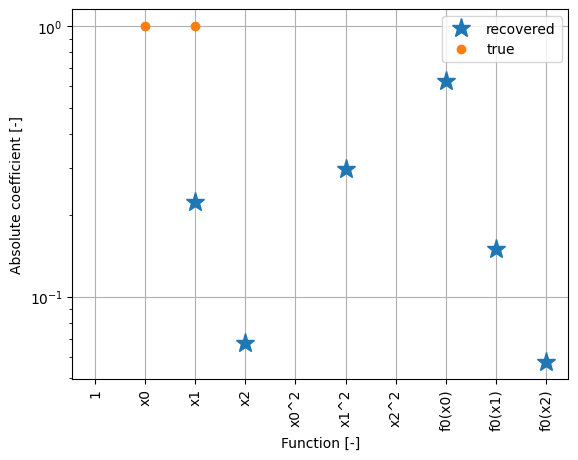

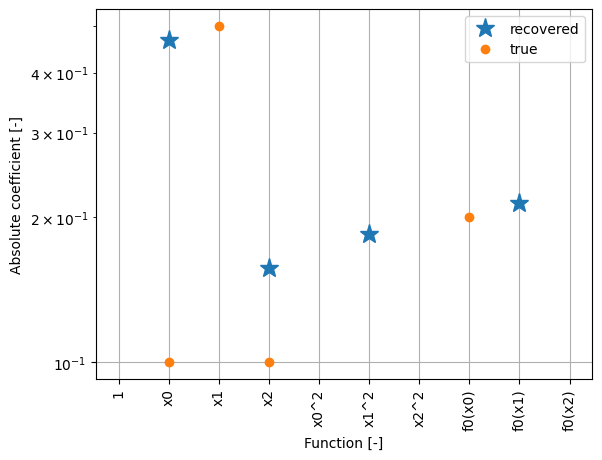

In [46]:
plt.semilogy(np.abs(NN_p[0]),"*", markersize=14)
plt.semilogy(np.abs(S_p_1),"o")
plt.xticks(ticks=np.arange(start=0,stop=len(function_names),step=1), labels=function_names, rotation=90)
plt.xlabel("Function [-]")
plt.ylabel("Absolute coefficient [-]")
plt.legend(["recovered","true"])
plt.grid()
plt.show()

plt.semilogy(np.abs(NN_p[1]),"*", markersize=14)
plt.semilogy(np.abs(S_p_2),"o")
plt.xticks(ticks=np.arange(start=0,stop=len(function_names),step=1), labels=function_names, rotation=90)
plt.xlabel("Function [-]")
plt.ylabel("Absolute coefficient [-]")
plt.legend(["recovered","true"])
plt.grid()
plt.show()

In [19]:
# x_1 = x_train[:-1]
# x_true = x_train[1:]
# x1_c = [0.99878565,  0.01999398]#
# x2_c = [-0.0199617 ,  0.99878345]#
# x0 = x_1[0]

# x_pred = []
# x_sim = [x0]

# for idx, x in enumerate(x_1):
#   x_pred.append(np.array([x1_c[0]*x[0]+x1_c[1]*x[1], x2_c[0]*x[0]+x2_c[1]*x[1]]))
#   x_sim.append(np.array([x1_c[0]*x_sim[idx][0]+x1_c[1]*x_sim[idx][1], x2_c[0]*x_sim[idx][0]+x2_c[1]*x_sim[idx][1]]))

# x_sim.pop(0)


# plt.plot(range(0,x_true.shape[0]), x_true,"*")
# plt.plot(range(0,x_1.shape[0]),x_1,'o')
# plt.plot(range(0,len(x_pred)),x_pred,'--')
# plt.plot(range(0,len(x_sim)),x_sim,'-o')
# plt.xlim([-1, 30])

In [20]:
c = np.c_[NN_p[0], NN_p[1]]

In [21]:
x_t = x_data[10000:50001,:-1]
u_t = x_data[10000:50000,-1]

x0 = x_t[0,:-1]
x_p = np.zeros(x_t.shape)
x_p[0] = x0

for idx, u in enumerate(u_t):
    input = np.r_[x_p[idx,:], u]
    Zeta = np.array(feature_library.fit(input).transform(input))
    x_p[idx+1,:] = np.matmul(Zeta,c)

In [22]:
def NRMS(y_pred, y_true):
    RMS = np.sqrt(np.mean((y_pred-y_true)**2))
    return RMS/np.std(y_true)

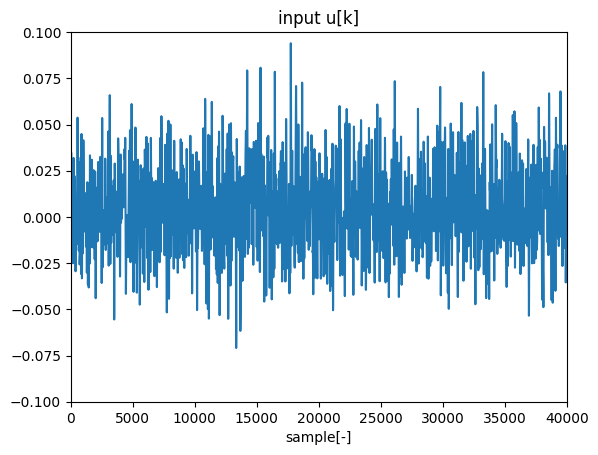

In [53]:
plt.plot(u_t)
plt.xlim([0, 40000])
plt.ylim([-0.1, 0.1])
plt.xlabel("sample[-]")
plt.title("input u[k]")
plt.show()

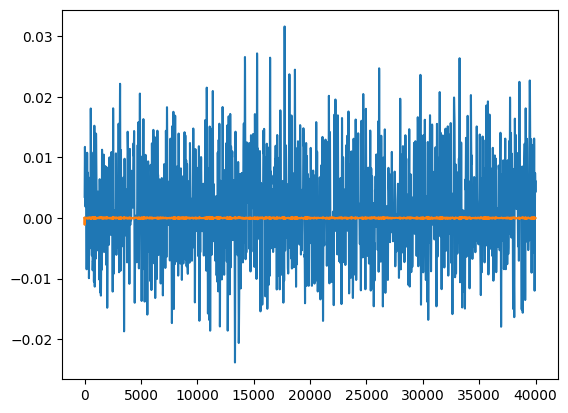

NRMS:  0.007760180858501974


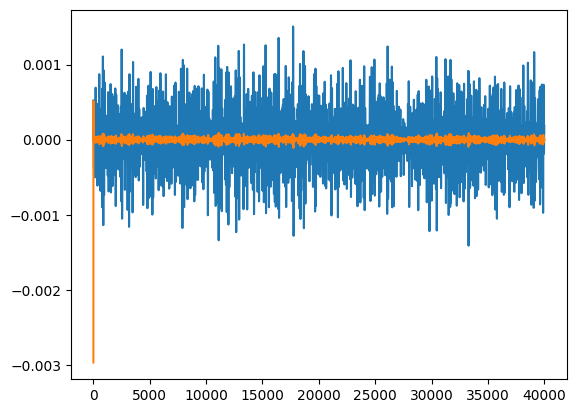

NRMS:  0.07803383038896966


In [23]:
# simulation
plt.plot(x_t[:,0])
plt.plot(x_t[:,0]-x_p[:,0])
plt.show()
print("NRMS: ",NRMS(x_t[:,0],x_p[:,0]))

plt.plot(x_t[:,1])
plt.plot(x_t[:,1]-x_p[:,1])
plt.show()

print("NRMS: ",NRMS(x_t[:,1],x_p[:,1]))

In [24]:
x0 = x_t[0,:-1]
x_p = np.zeros(x_t.shape)
x_p[0] = x0

with torch.no_grad():
    for idx, u in enumerate(u_t):
        input = np.r_[x_p[idx,:], u]
        Zeta = torch.as_tensor(np.array(feature_library.fit(input).transform(input))).to(torch.float32)
        x_p[idx+1,:] = model(Zeta)

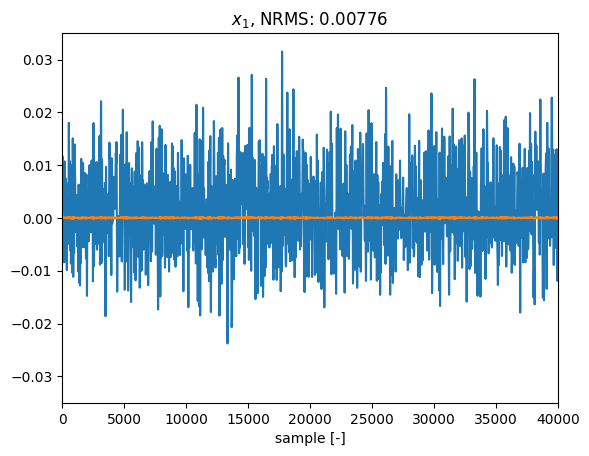

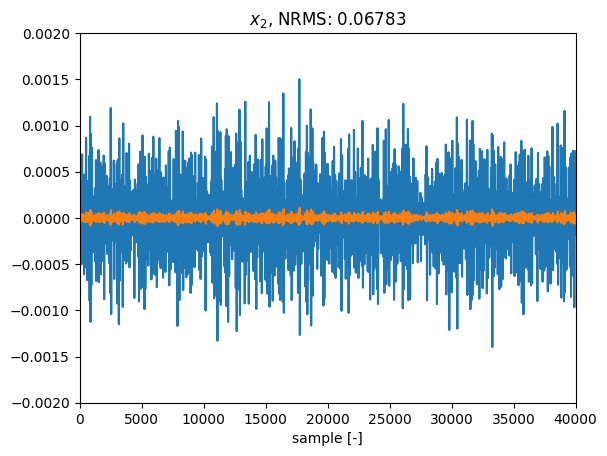

In [38]:
# simulation
plt.plot(x_p[:,0])
plt.plot(x_p[:,0]-x_t[:,0])
plt.title("$x_1$, NRMS: {}".format(round(NRMS(x_t[:,0],x_p[:,0]),5)))
plt.xlim([0, 40000])
plt.ylim([-0.035, 0.035])
plt.xlabel("sample [-]")
plt.show()
plt.plot(x_p[:,1])
plt.plot(x_p[:,1]-x_t[:,1])
plt.title("$x_2$, NRMS: {}".format(round(NRMS(x_t[10:,1],x_p[10:,1]),5)))
plt.xlim([0, 40000])
plt.ylim([-0.002, 0.002])
plt.xlabel("sample [-]")
plt.show()